In [ ]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
import time
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# function to do pca
def doPCAtraining(X_train, y_train):
  #3-9# A) using Dimensionaity Reduction with PCA

  #3a# dimensionality reducion with PCA
  print("Doing Dimensionality Reduction using PCA in train set")
  print("========================================================")
  print(f"Train data shape before PCA DR: {X_train.shape}")

  #now run a PCA, preserving 99% of variance
  pca_start_time = time.time()
  pca = PCA(0.99, whiten=True)
  #remember: PCA takes as input a 2d matrix: n paradigms x m features
  pca_train_data = pca.fit_transform(X_train.reshape(X_train.shape[0], (X_train.shape[1]*X_train.shape[2])))

  pca_time = time.time() - pca_start_time
  print(f"PCA Training time: {round(pca_time,2)} secs")

  #pca_train_data.shape
  print(f"Train data shape after PCR DR: {pca_train_data.shape}")
  print("--------------------------------------------------------")

  #4a# print randomly 10 images BEFORE and AFTER dimensionality reducion from the train set dataset
  # inverse tha pca data to demonstate the outcomes
  inversed_pca_data = pca.inverse_transform(pca_train_data)
  #remember to reshape the 2d to 3d for the plotFashionItems function to work
  inversedTrainData = inversed_pca_data.reshape(inversed_pca_data.shape[0], X_train.shape[1],X_train.shape[2])

  #select random index from each class to print
  randomIndexes = getRandomIndexes(y_train)

  # create 2 lists, 1 from the original data, 1 from the reducted data, using the random indexes
  beforeDRImages = X_train[randomIndexes]
  afterDRImages = inversedTrainData[randomIndexes]
  print("Random images BEFORE (1st row) and AFTER (2nd row) Dimensionality Reduction using PCA")
  print("--------------------------------------------------------")
  plotFashionItems(beforeDRImages)
  plotFashionItems(afterDRImages)

  #5a# print plot to show that pca will work
  print()
  plot_2d(inversed_pca_data, y_train, 'PCA')
  plot_3d(inversed_pca_data, y_train, 'PCA')

  return pca, pca_time

In [ ]:
# function to find the best k to use for minibatch kmeans after pca
def findBestMinibatchKPCA(pca, X_validate, y_validate):
  print("Trying to find the best k to use with Minibatch k means using validation set after PCA")
  print("Please wait...")
  print("=======================================================")
  pca_validate_data = pca.fit_transform(X_validate.reshape(X_validate.shape[0], (X_validate.shape[1]*X_validate.shape[2])))

  minibatchKscores = []
  maxScore = -1
  bestK = 0

  #testing which k is best for kmeans
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    mbkm_start_time = time.time()
    mbkm = cluster.MiniBatchKMeans(n_clusters = numOfClust)
    mbkm.fit(pca_validate_data)
    mbkmLabels = mbkm.labels_
    mbkm_time = time.time() - mbkm_start_time
    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), mbkmLabels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    minibatchKscores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(mbkm_time,4)})
    addToBestKDataframe("PCA", "Minibatch K Means", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("--------------------------------------------------------")
  return bestK


In [ ]:
# function to find best k to use in aggromerative clustering after pca
def findBestAgClustKPCA(pca, X_validate, y_validate):
  print("Trying to find the best k to use with Agglomerative Clustering using validation set after PCA")
  print("Please wait...")
  print("=======================================================")
  pca_validate_data = pca.fit_transform(X_validate.reshape(X_validate.shape[0], (X_validate.shape[1]*X_validate.shape[2])))

  agglomerativeKScores = []
  maxScore = -1
  bestK = 0

  #testing which k is best for agglomerative clustering
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    ag_start_time = time.time()
    average_linkage = AgglomerativeClustering(n_clusters=numOfClust, linkage='average')
    average_labels = average_linkage.fit_predict(pca_validate_data)
    ag_time = time.time() - ag_start_time

    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), average_labels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    agglomerativeKScores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(ag_time,4)})
    addToBestKDataframe("PCA", "Agglomerative Clustering", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("=======================================================")
  return bestK

In [ ]:
# function to run PCA on test data and run the clustering techniques
def doPCAtest(pca, pca_time, X_test, y_test, bestMinibatchK, bestAGClustK):
  #6a# use pca on test data
  #apply the existing PCA transform to the test set
  print(f"Test data shape before DR: {X_test.shape}")
  pca_test_data_set = pca.transform(X_test.reshape(X_test.shape[0], (X_test.shape[1]*X_test.shape[2])))
  print(f"Test data shape after DR: {pca_test_data_set.shape}")
  print("========================================================")

  runMinibatchKmeans("PCA", pca_test_data_set, pca_time, bestMinibatchK)
  print("--------------------------------------------------------")
  runAgglomerativeClustering("PCA", pca_test_data_set, pca_time, bestAGClustK)

In [ ]:
# function to build SAE and use training set to train
def doSAETraining(X_train, y_train, X_validate, y_validate):
  #3-9# B) using Dimensionaity Reduction with SAE
    print("Doing Dimensionality Reduction using Stacked AutoEncoder (SAE) in train set")
    print("========================================================")
    sae_start_time = time.time()
    print(X_train.shape)
    input_dim = X_train.shape[1]
    encoding_dim = 64  # Compressed size

    # SAE architecture
    input_img = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_img)
    encoded = Dense(256, activation='relu')(encoded)
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(bottleneck)
    decoded = Dense(512, activation='relu')(decoded)
    output = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_img, output)
    encoder = Model(input_img, bottleneck)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train autoencoder
    autoencoder.fit(X_train, X_train,
                    epochs=20,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_validate, X_validate),
                    verbose=1)

    sae_time = time.time() - sae_start_time
    print(f"SAE Training time: {round(sae_time, 2)} secs")
    print("========================================================")

    # Inverse-transform some data for visualization
    decoded_imgs = autoencoder.predict(X_train)
    inversedTrainData = decoded_imgs.reshape((-1, 28, 28))
    randomIndexes = getRandomIndexes(y_train)

    beforeDRImages = X_train[randomIndexes].reshape((-1, 28, 28))
    afterDRImages = inversedTrainData[randomIndexes]

    print("Random images BEFORE (1st row) and AFTER (2nd row) Dimensionality Reduction using SAE.")
    print("========================================================")
    plotFashionItems(beforeDRImages)
    plotFashionItems(afterDRImages)

    print()
    plot_2d(decoded_imgs, y_train, 'SAE')
    plot_3d(decoded_imgs, y_train, 'SAE')

    return autoencoder, encoder, sae_time

In [ ]:
def findBestMinibatchKSAE(encoder, X_validate, y_validate):
  print("Trying to find the best k to use with Minibatch k using validation set after SAE")
  print("Please wait...")
  print("=======================================================")
  minibatchKscores = []
  maxScore = -1
  bestK = 0

  sae_validate_data = encoder.predict(X_validate)

  #testing which k is best for kmeans
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    mbkm_start_time = time.time()
    mbkm = cluster.MiniBatchKMeans(n_clusters = numOfClust)
    mbkm.fit(sae_validate_data)
    mbkmLabels = mbkm.labels_
    mbkm_time = time.time() - mbkm_start_time
    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), mbkmLabels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    minibatchKscores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(mbkm_time,4)})
    addToBestKDataframe("SAE", "Minibatch K Means", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("--------------------------------------------------------")
  return bestK

In [ ]:
def findBestAgClustKSAE(encoder, X_validate, y_validate):
  print("Trying to find the best k to use with Agglomerative Clustering using validation set after SAE")
  print("Please wait...")
  print("=======================================================")

  agglomerativeKScores = []
  maxScore = -1
  bestK = 0

  sae_validate_data = encoder.predict(X_validate)

  #testing which k is best for agglomerative clustering
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    ag_start_time = time.time()
    average_linkage = AgglomerativeClustering(n_clusters=numOfClust, linkage='average')
    average_labels = average_linkage.fit_predict(sae_validate_data)
    ag_time = time.time() - ag_start_time

    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), average_labels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    agglomerativeKScores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(ag_time,4)})
    addToBestKDataframe("SAE", "Agglomerative Clustering", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("--------------------------------------------------------")
  return bestK

In [ ]:
def doSAETest(encoder, sae_time, X_test, y_test, bestMinibatchK, bestAGClustK):
  sae_test_data = encoder.predict(X_test)

  runMinibatchKmeans("SAE", sae_test_data, sae_time, bestMinibatchK)
  runAgglomerativeClustering("SAE", sae_test_data, sae_time, bestAGClustK)

In [ ]:
def findBestMinibatchKRaw(X_validate, y_validate):
  print("Trying to find the best k to use with Minibatch k means using validation set from raw data")
  print("Please wait...")
  print("=======================================================")
  minibatchKscores = []
  maxScore = -1
  bestK = 0

  raw_validate_flat = X_validate.reshape(X_validate.shape[0], -1)

  #testing which k is best for kmeans
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    mbkm_start_time = time.time()
    mbkm = cluster.MiniBatchKMeans(n_clusters = numOfClust)
    mbkm.fit(raw_validate_flat)
    mbkmLabels = mbkm.labels_
    mbkm_time = time.time() - mbkm_start_time
    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), mbkmLabels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    minibatchKscores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(mbkm_time,4)})
    addToBestKDataframe("Raw", "Minibatch K Means", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("--------------------------------------------------------")
  return bestK

In [ ]:
def findBestAgClustKRaw(X_validate, y_validate):
  print("Trying to find the best k to use with Agglomerative Clustering using validation set from raw data")
  print("Please wait...")
  print("=======================================================")

  agglomerativeKScores = []
  maxScore = -1
  bestK = 0

  raw_validate_flat = X_validate.reshape(X_validate.shape[0], -1)
  #testing which k is best for agglomerative clustering
  for numOfClust in range (5,11):
    print('Currently testing', str(numOfClust), 'number of clusters')
    ag_start_time = time.time()
    average_linkage = AgglomerativeClustering(n_clusters=numOfClust, linkage='average')
    average_labels = average_linkage.fit_predict(raw_validate_flat)
    ag_time = time.time() - ag_start_time

    silh_score, ch_score, db_score =  performance_score( y_validate.reshape(-1, 1), average_labels)
    # check if this is the max score
    if silh_score > maxScore:
      maxScore = silh_score
      bestK = numOfClust

    agglomerativeKScores.append({"k" : numOfClust ,"finalScore" : silh_score, "time" : round(ag_time,4)})
    addToBestKDataframe("Raw", "Agglomerative Clustering", numOfClust, silh_score, ch_score, db_score)
    print("--------------------------------------------------------")

  print(f"The best final score is {maxScore} using {bestK} clusters")
  print("--------------------------------------------------------")
  return bestK

In [ ]:
def doRaw(y_train, X_test, bestMinibatchK, bestAGClustK):
  #3-9# C) using Raw Data
  #3c# skipped because we dont run Dimersionality Reduction
  #4c# print random images, one from each class, from the original data
  print("Using Raw data on train set")
  print("========================================================")
  randomIndexes = getRandomIndexes(y_train)
  rawImages = X_train[randomIndexes]
  plotFashionItems(rawImages)
  #5c# skipped because we dont run Dimensionality Reduction
  #6c# skipped because we dont run Dimensionality Reduction
  print(f"Test data shape before flatening: {X_test.shape}")
  #flaten the test set so clustering techniques can work
  X_test_flat = X_test.reshape(X_test.shape[0], -1)
  print(f"Test data shape after flatening: {X_test_flat.shape}")
  print("--------------------------------------------------------")

  runMinibatchKmeans("Raw", X_test_flat, 0, bestMinibatchK )
  runAgglomerativeClustering("Raw", X_test_flat, 0, bestAGClustK)

In [ ]:
# function to run Minibatch kmeans technique
def runMinibatchKmeans(drTechnique, test_data_set, drTechTime, bestk ):
    #7a1# 1. Using minibatch k means clustering technique
    print(f"Using Minibatch K Means on test set for {bestk} clusters ")
    print("--------------------------------------------------------")
    clusteringAlgorithm = "MiniBatchKMeans"

    mbkm_start_time = time.time()
    mbkm = cluster.MiniBatchKMeans(n_clusters = bestk)
    mbkm.fit(test_data_set)
    mbkmLabels = mbkm.labels_
    mbkm_time = time.time() - mbkm_start_time

    # #8a1# calculate the scores
    silh_score, ch_score, db_score =  performance_score( y_test.reshape(-1, 1), mbkmLabels)

    #9a1# store the results in pandas dataframe
    addToDataframe(drTechnique, clusteringAlgorithm, drTechTime, mbkm_time, bestk, silh_score, ch_score, db_score, test_data_set, mbkmLabels )

In [ ]:
# function to run Agglomerative Clustering technique
def runAgglomerativeClustering(drTechnique, test_data_set, drTechTime, bestk ):
    #7a2# 2. Using agglomerative clustering technique
    print(f"Using Agglomerative Clustering on test set for {bestk} clusters :")
    print("--------------------------------------------------------")
    clusteringAlgorithm = "Agglomerative Clustering"
    ag_start_time = time.time()
    average_linkage = AgglomerativeClustering(n_clusters=bestk, linkage='average')
    average_labels = average_linkage.fit_predict(test_data_set)
    ag_time = time.time() - ag_start_time

    print(f"Agglomerative Clustering Execution time: {round(ag_time,2)} secs")
    #8a2# calculate the scores
    silh_score, ch_score, db_score = performance_score( y_test.reshape(-1, 1), average_labels)
    print("--------------------------------------------------------")
    #9a2# store the results in pandas dataframe
    addToDataframe(drTechnique, clusteringAlgorithm, drTechTime, ag_time, bestk, silh_score, ch_score, db_score, test_data_set, average_labels )

In [ ]:
# function to add results to dataframe
def addToDataframe(drTechnique, clusteringAlgorithm, trainingTime, executionTime, suggestedClusters, silh_score, ch_score, db_score, transformed_data, predicted_labels) :
  global resultsDataframe, allClusteringRuns
  newData = pd.DataFrame([{"DR technique": drTechnique,"Clustering Algorithm": clusteringAlgorithm, "DR Tech. Training Time (secs)": round(trainingTime,2), "Clustring Tech. Execution Time (secs)": round(executionTime,2), "Suggested Clusters": suggestedClusters,\
                                  "Silhouette score":round(silh_score,2), "Calinski-Harabasz index": round(ch_score,2), "Davies-Bouldin index": round(db_score,2)}])

  resultsDataframe = pd.concat([resultsDataframe, newData], ignore_index=True)

  # Store full data and labels in a parallel structure
  allClusteringRuns.append({"drTechnique": drTechnique, "clusteringAlgorithm": clusteringAlgorithm,"transformedData": transformed_data, "labels": predicted_labels})

In [ ]:
# function to add results to dataframe for bestK
def addToBestKDataframe(drTechnique, clusteringAlgorithm, k, silh_score, ch_score, db_score) :
  global bestKDataframe
  newData = pd.DataFrame([{"DR Technique": drTechnique,"Clustering Algorithm": clusteringAlgorithm, "Number of Clusters": k,\
                                  "Silhouette score":round(silh_score,2), "Calinski-Harabasz index": round(ch_score,2), "Davies-Bouldin index": round(db_score,2)}])

  bestKDataframe = pd.concat([bestKDataframe, newData], ignore_index=True)

In [ ]:
# function to show pictures from dataset
def plotFashionItems(data):
    fig, ax = plt.subplots(1, 10, figsize=(28, 28),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='binary')
        #im.set_clim(0, 16)
        im.set_clim(0, 1)

In [ ]:
# function for performance scores
def performance_score(input_values, cluster_indexes):
    try:
        silh_score = metrics.silhouette_score(input_values, cluster_indexes)
        print(' .. Silhouette Coefficient score is {:.2f}'.format(silh_score))
        #print( ' ... -1: incorrect, 0: overlapping, +1: highly dense clusts.')
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

    try:
        ch_score =\
         metrics.calinski_harabasz_score(input_values, cluster_indexes)
        print(' .. Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
        #print(' ... Higher the value better the clusters.')
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        db_score = metrics.davies_bouldin_score(input_values, cluster_indexes)
        print(' .. Davies-Bouldin Index score is {:.2f}'.format(db_score))
        #print(' ... 0: Lowest possible value, good partitioning.')
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    return silh_score, ch_score, db_score

In [ ]:
# function to get random indexes
def getRandomIndexes(y_train):
  classes = np.unique(y_train)
  randomIndexes = []

  for cls in classes:
      indices = np.where(y_train == cls)[0]
      randomIndex = np.random.choice(indices)
      randomIndexes.append(randomIndex)
  return randomIndexes

In [ ]:
# Helper function for 2D plots
def plot_2d(X_proj, y, title):
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(X_proj[y == label, 0], X_proj[y == label, 1], label=f'Class {label}')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

def plot_3d(X_proj, y, title):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y):
        ax.scatter(X_proj[y == label, 0], X_proj[y == label, 1], X_proj[y == label, 2], label=f'Class {label}')
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend()
    plt.show()

In [ ]:
#1# load dataset
# import the dataset
#dataset is already split in train and test set. 60K images train set data, 10K images test set data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#normalize the sets
X_train, X_test = X_train / 255.0, X_test / 255.0
print("Data Normalized")

#2# split the train data in train-validation data
# validate the set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

#create dataframe to store clustering results with specified columns
columns = ["DR technique", "Clustering Algorithm", "DR Tech. Training Time (secs)", "Clustring Tech. Execution Time (secs)", "Suggested Clusters", "Silhouette score", "Calinski-Harabasz index", "Davies-Bouldin index"]
resultsDataframe = pd.DataFrame(columns=columns)

#create to store all clustring runs
allClusteringRuns = []

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data Normalized


Doing Dimensionality Reduction using PCA in train set
Train data shape before PCA DR: (54000, 28, 28)
PCA Training time: 4.11 secs
Train data shape after PCR DR: (54000, 459)
--------------------------------------------------------
Random images BEFORE (1st row) and AFTER (2nd row) Dimensionality Reduction using PCA
--------------------------------------------------------



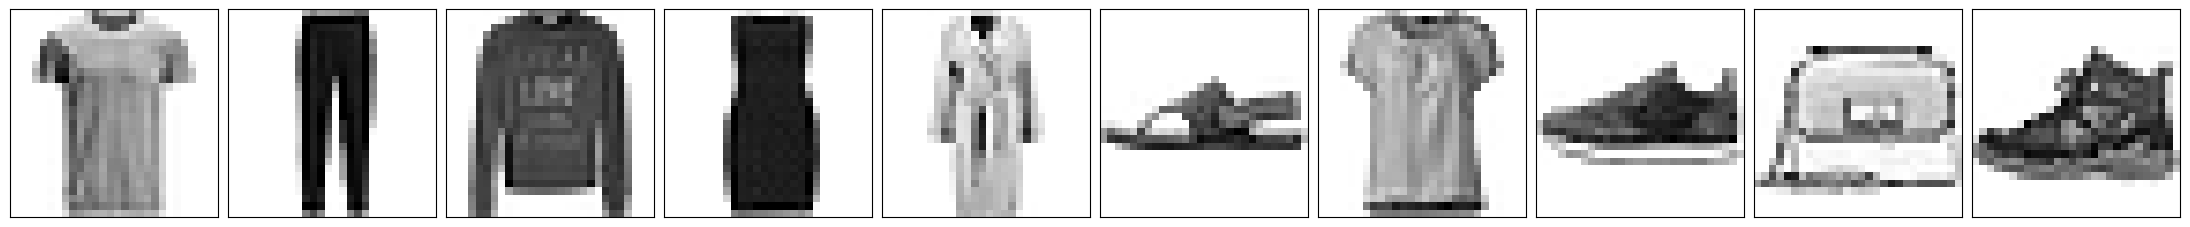

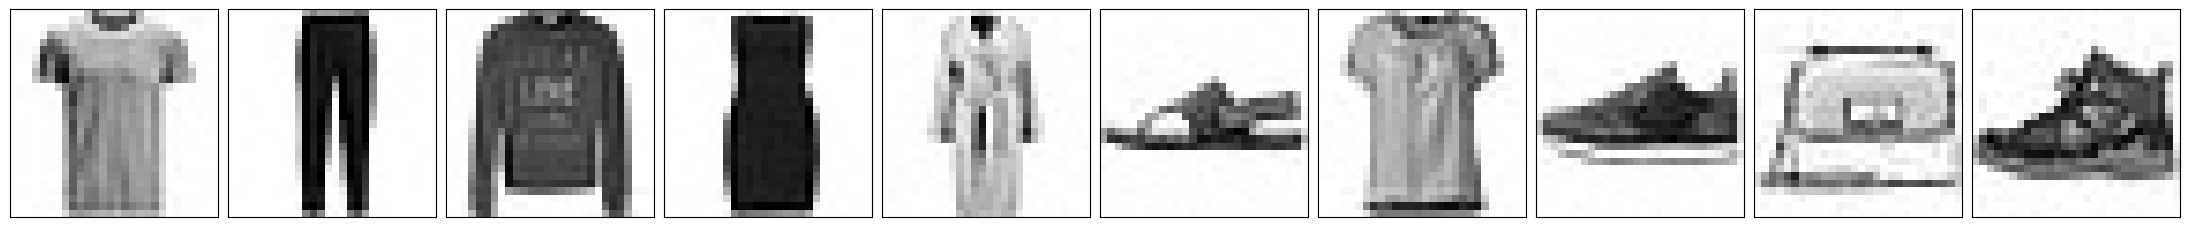

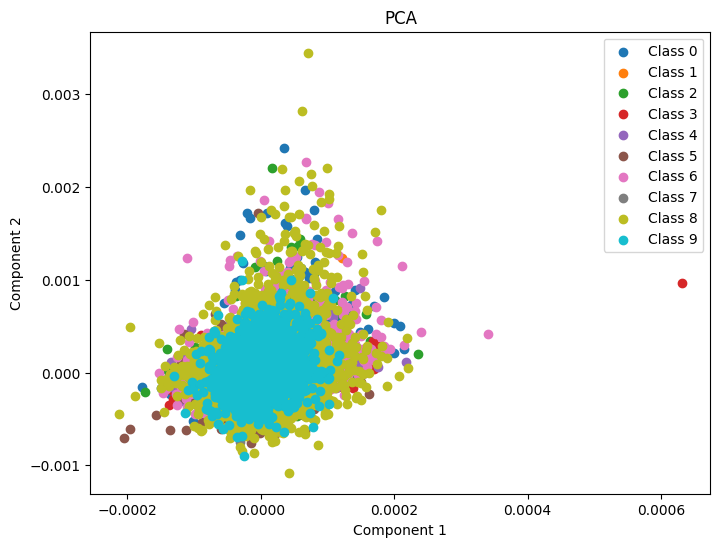

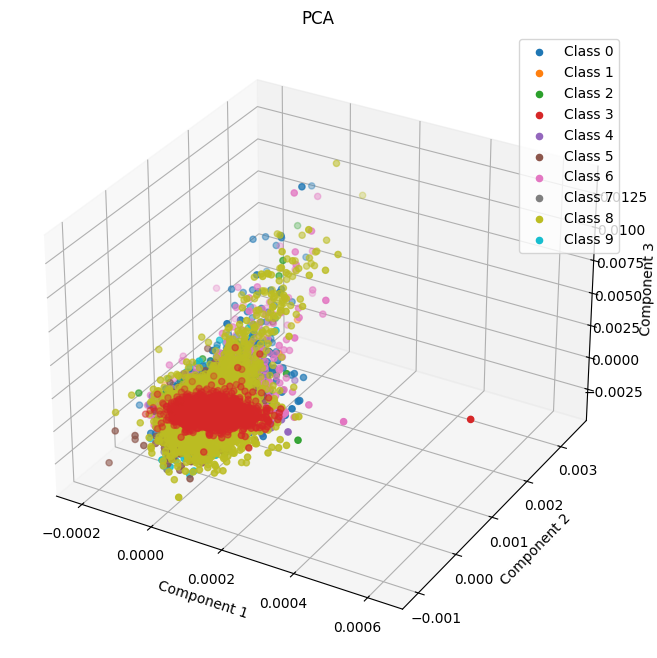

In [ ]:
#3a-4a-5a# do Dimensionality Reduction using PCA on train set
pca, pca_time = doPCAtraining(X_train, y_train)

In [ ]:
#create dataframe to store clustering results to find best K
columnsK = ["DR Technique", "Clustering Algorithm", "Number of Clusters", "Silhouette score", "Calinski-Harabasz index", "Davies-Bouldin index"]
bestKDataframe = pd.DataFrame(columns=columnsK)

#trying to find the best k for minibatch after pca using validation set
bestMinibatchK = findBestMinibatchKPCA(pca, X_validate, y_validate)

#trying to find the best k for agglomerative clustering after pca using validation set
bestAGClustK = findBestAgClustKPCA(pca, X_validate, y_validate)

Trying to find the best k to use with Minibatch k means using validation set after PCA
Please wait...
Currently testing 5 number of clusters
 .. Silhouette Coefficient score is -0.74
 .. Calinski-Harabasz Index score is 74.93
 .. Davies-Bouldin Index score is 1.37
--------------------------------------------------------
Currently testing 6 number of clusters


<ipython-input-37-86b24f5e1acd>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bestKDataframe = pd.concat([bestKDataframe, newData], ignore_index=True)


 .. Silhouette Coefficient score is -0.62
 .. Calinski-Harabasz Index score is 2.52
 .. Davies-Bouldin Index score is 8.33
--------------------------------------------------------
Currently testing 7 number of clusters
 .. Silhouette Coefficient score is -0.56
 .. Calinski-Harabasz Index score is 154.79
 .. Davies-Bouldin Index score is 66.31
--------------------------------------------------------
Currently testing 8 number of clusters
 .. Silhouette Coefficient score is -0.79
 .. Calinski-Harabasz Index score is 0.78
 .. Davies-Bouldin Index score is 72.51
--------------------------------------------------------
Currently testing 9 number of clusters
 .. Silhouette Coefficient score is -0.80
 .. Calinski-Harabasz Index score is 33.79
 .. Davies-Bouldin Index score is 3.73
--------------------------------------------------------
Currently testing 10 number of clusters
 .. Silhouette Coefficient score is -0.76
 .. Calinski-Harabasz Index score is 47.88
 .. Davies-Bouldin Index score is

In [ ]:
#6a-7a-8a-9a# do Dimensionality Reduction using PCA on test set, run Minibatch Kmeans and Agglomerative Clustering Techniques and print the scores
doPCAtest(pca, pca_time, X_test, y_test, bestMinibatchK, bestAGClustK)

Test data shape before DR: (10000, 28, 28)
Test data shape after DR: (10000, 434)
Using Minibatch K Means on test set for 7 clusters 
--------------------------------------------------------
 .. Silhouette Coefficient score is -0.63
 .. Calinski-Harabasz Index score is 20.44
 .. Davies-Bouldin Index score is 3.00
--------------------------------------------------------
Using Agglomerative Clustering on test set for 5 clusters :
--------------------------------------------------------


<ipython-input-36-f77540e56d21>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsDataframe = pd.concat([resultsDataframe, newData], ignore_index=True)


Agglomerative Clustering Execution time: 25.22 secs
 .. Silhouette Coefficient score is -0.32
 .. Calinski-Harabasz Index score is 0.64
 .. Davies-Bouldin Index score is 1.27
--------------------------------------------------------


Doing Dimensionality Reduction using Stacked AutoEncoder (SAE) in train set
(54000, 784)
Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0637 - val_loss: 0.0234
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0203 - val_loss: 0.0170
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━

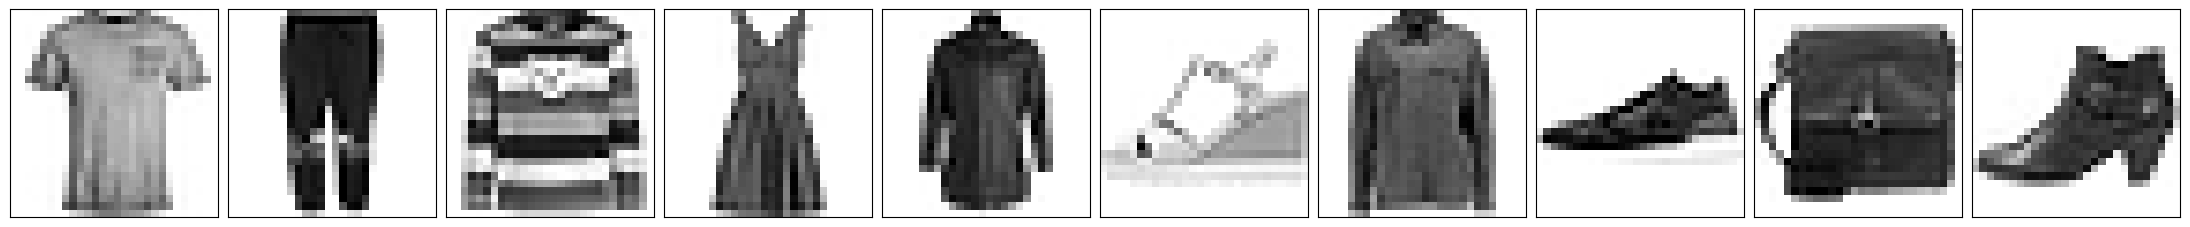

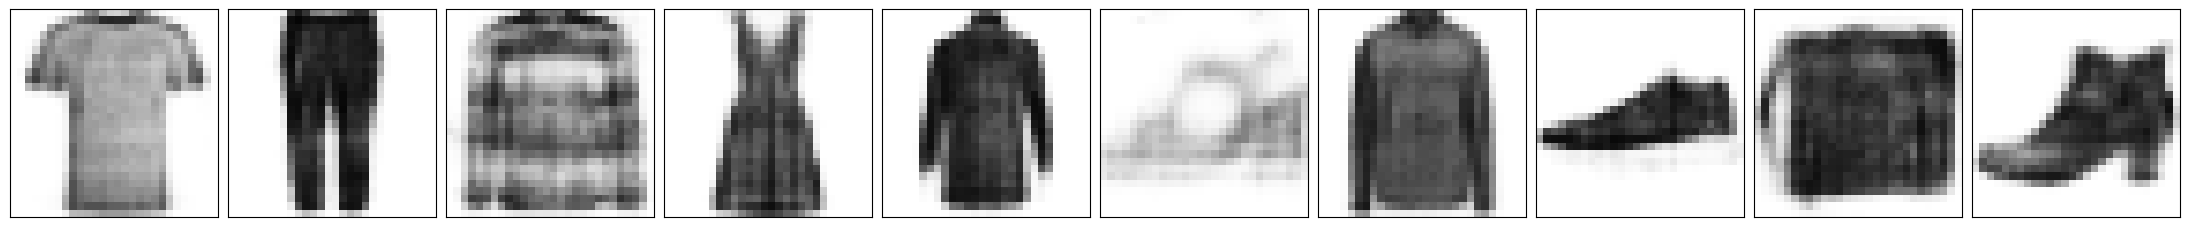

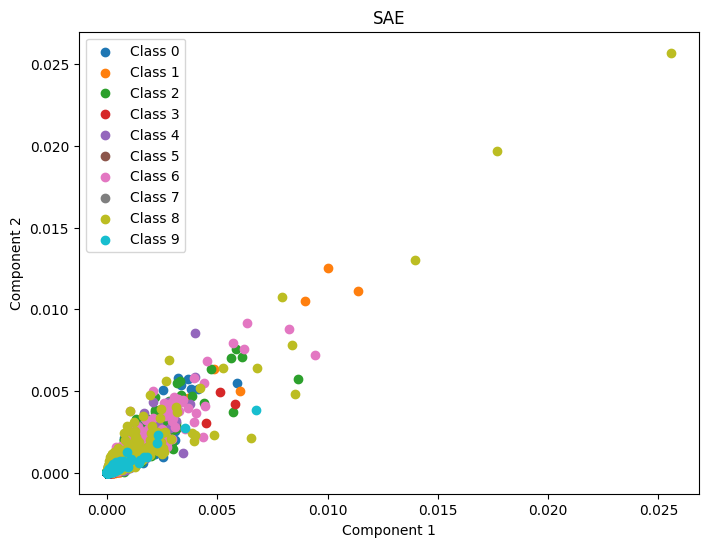

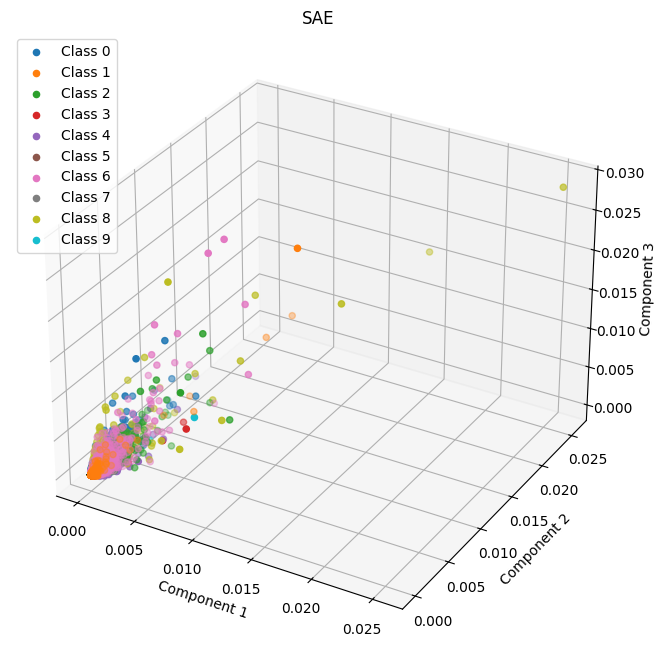

In [ ]:
#3b-4b-5b-6b-7b-8b-9b# do Dimensionality Reduction using SAE on train set
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_validate_flat = X_validate.reshape((X_validate.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))
autoencoder, encoder, sae_time = doSAETraining(X_train_flat, y_train, X_validate_flat, y_validate)

In [ ]:
#trying to find the best k for minibatch with SAE validation set
bestMinibatchK = findBestMinibatchKSAE(encoder, X_validate_flat, y_validate)
#trying to find the best k for agglomerative clustering with SAE validation set
bestAGClustK = findBestAgClustKSAE(encoder, X_validate_flat, y_validate)

Trying to find the best k to use with Minibatch k using validation set after SAE
Please wait...
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Currently testing 5 number of clusters
 .. Silhouette Coefficient score is -0.06
 .. Calinski-Harabasz Index score is 1461.38
 .. Davies-Bouldin Index score is 27.52
--------------------------------------------------------
Currently testing 6 number of clusters
 .. Silhouette Coefficient score is -0.08
 .. Calinski-Harabasz Index score is 1369.85
 .. Davies-Bouldin Index score is 8.22
--------------------------------------------------------
Currently testing 7 number of clusters
 .. Silhouette Coefficient score is -0.14
 .. Calinski-Harabasz Index score is 1129.15
 .. Davies-Bouldin Index score is 10.62
--------------------------------------------------------
Currently testing 8 number of clusters
 .. Silhouette Coefficient score is -0.21
 .. Calinski-Harabasz Index score is 885.30
 .. Davies-Bouldin Index score is 6.12
-------------------------------

In [ ]:
# run clustering methods with SAE test set
X_test_flat = X_test.reshape((X_test.shape[0], -1))
doSAETest(encoder, sae_time, X_test_flat, y_test, bestMinibatchK, bestAGClustK)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Using Minibatch K Means on test set for 5 clusters 
--------------------------------------------------------
 .. Silhouette Coefficient score is -0.05
 .. Calinski-Harabasz Index score is 2466.00
 .. Davies-Bouldin Index score is 9.21
Using Agglomerative Clustering on test set for 5 clusters :
--------------------------------------------------------
Agglomerative Clustering Execution time: 9.25 secs
 .. Silhouette Coefficient score is -0.22
 .. Calinski-Harabasz Index score is 437.68
 .. Davies-Bouldin Index score is 2.11
--------------------------------------------------------


In [ ]:
#3c-4c-5c-6c-7c-8c-9c# test the clustering methods using raw data
#trying to find the best k for minibatch with raw data validation set
bestMinibatchK = findBestMinibatchKRaw(X_validate, y_validate)
#trying to find the best k for agglomerative clustering with raw data validation set
bestAGClustK = findBestAgClustKRaw(X_validate, y_validate)

Trying to find the best k to use with Minibatch k means using validation set from raw data
Please wait...
Currently testing 5 number of clusters
 .. Silhouette Coefficient score is 0.02
 .. Calinski-Harabasz Index score is 2067.02
 .. Davies-Bouldin Index score is 2.71
--------------------------------------------------------
Currently testing 6 number of clusters
 .. Silhouette Coefficient score is 0.01
 .. Calinski-Harabasz Index score is 1489.37
 .. Davies-Bouldin Index score is 12.89
--------------------------------------------------------
Currently testing 7 number of clusters
 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 1347.97
 .. Davies-Bouldin Index score is 7.75
--------------------------------------------------------
Currently testing 8 number of clusters
 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 1394.49
 .. Davies-Bouldin Index score is 19.98
--------------------------------------------------------
Curren

Using Raw data on train set
Test data shape before flatening: (10000, 28, 28)
Test data shape after flatening: (10000, 784)
--------------------------------------------------------
Using Minibatch K Means on test set for 5 clusters 
--------------------------------------------------------
 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 2643.37
 .. Davies-Bouldin Index score is 2.99
Using Agglomerative Clustering on test set for 5 clusters :
--------------------------------------------------------
Agglomerative Clustering Execution time: 34.85 secs
 .. Silhouette Coefficient score is -0.39
 .. Calinski-Harabasz Index score is 1760.49
 .. Davies-Bouldin Index score is 4.29
--------------------------------------------------------


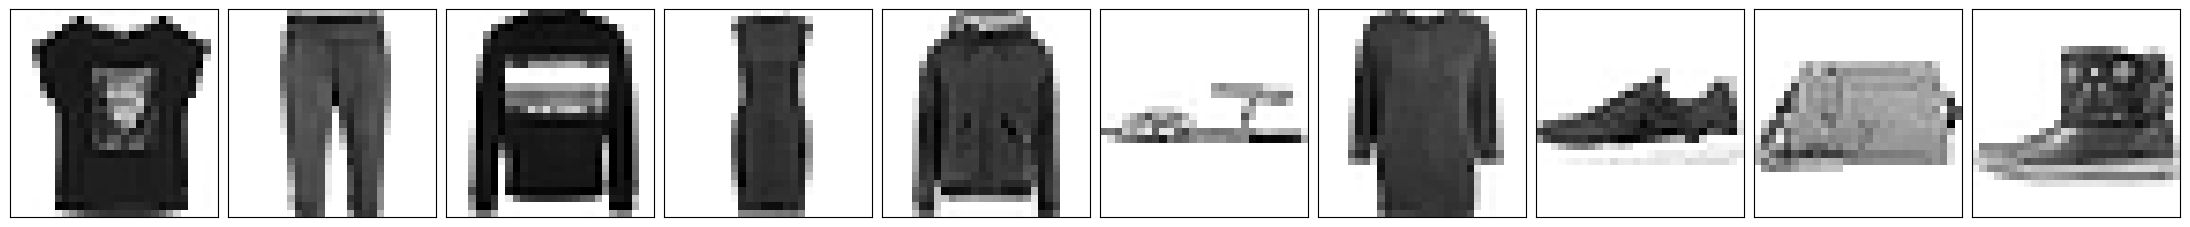

In [ ]:
# run clustering methods on raw data test set
doRaw(y_train, X_test, bestMinibatchK, bestAGClustK)

Best method is using Raw and clustering with MiniBatchKMeans based on the Silhouette score
Printing 10 random images from 2 randomly selected clusters from the best method


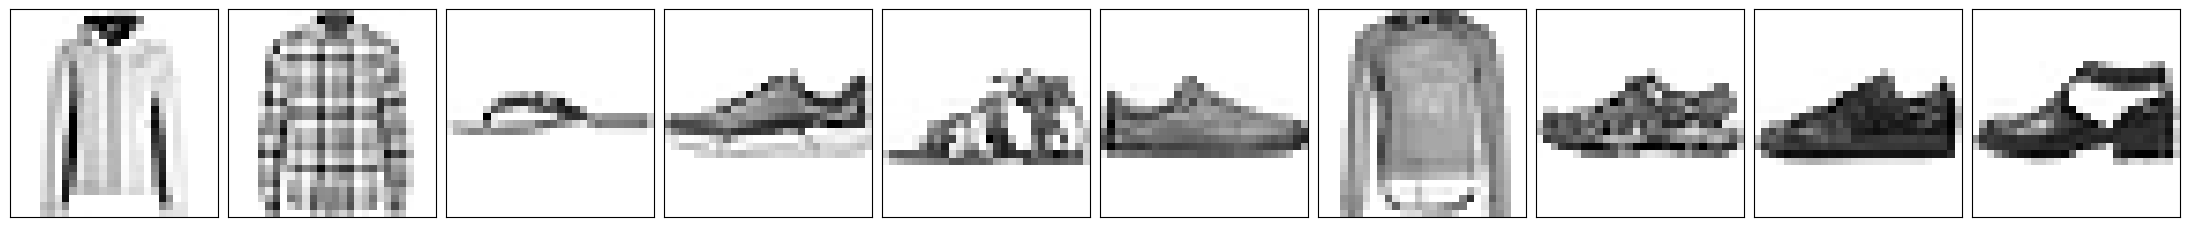

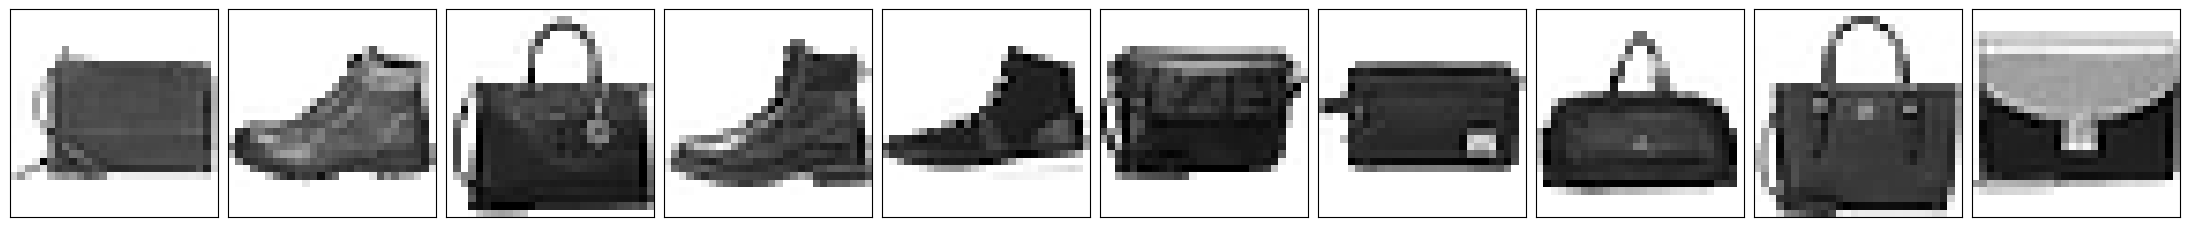

In [ ]:
#10#  from the best clustreing method among all tries, select 2 random clusters and print 10 images from each
# Find the index of the best silhouette score
bestIndex = resultsDataframe["Silhouette score"].idxmax()

# select the best method data
bestMethod = allClusteringRuns[bestIndex]
bestMethodDR = bestMethod["drTechnique"]
bestMethodClustering = bestMethod["clusteringAlgorithm"]
bestMethodData = bestMethod["transformedData"]
bestMethodLabels = bestMethod["labels"]

print(f"Best method is using {bestMethodDR} and clustering with {bestMethodClustering} based on the Silhouette score")
print("Printing 10 random images from 2 randomly selected clusters from the best method")
#remember to reshape the 2d to 3d for the plotFashionItems function to work
inversedBestMethodData = bestMethodData.reshape(bestMethodData.shape[0], X_test.shape[1],X_test.shape[2])
#print(inversedBestMethodData.shape)

unique_labels = np.unique(bestMethodLabels)
# Choose 2 labels randomly
selected_labels = np.random.choice(unique_labels, 2, replace=False)

for label in selected_labels:
    # Get indices for all items with the current label
    indices = np.where(bestMethodLabels == label)[0]

    # Get the corresponding data/images
    data_for_label = inversedBestMethodData[indices]
    plotFashionItems(data_for_label)

resultsDataframe.to_csv('/content/drive/My Drive/clusteringResults.csv', index=False)
bestKDataframe.to_csv('/content/drive/My Drive/bestKResults.csv', index=False)